In [1]:
%matplotlib inline

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
plt.rcParams['figure.dpi']=200


In [2]:
class Venus:
    # note: always set the func paramter
    def __init__(
        self,
        inj_limits=[97, 110],
        mid_limits=[97, 110],
        ext_limits=[116, 128],
        beam_range=[0.50, 1.00],
        jitter=0, 
        func = (lambda X: -1)
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)
        self.func = func

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self.func(self.currents)

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [3]:
venus = Venus(jitter=0.15)

set the currents and read the beam value

In [4]:
venus.set_mag_currents(100, 100, 120)
bc = venus.get_beam_current()
print(bc)

-1


if currents are outside the range a `ValueError` is raised and can be captured.

In [5]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

# Bayesian Optimization

In [6]:
# import the function we are trying to optimize
gpr_model1 = pickle.load(open("Models/1stRunGPR.dump","rb"))
normalizer1 = lambda X: (X - [103.16726412, 103.05644853, 122.86389106] )/ [3.54492885, 3.87407133, 3.28592364]
func1 = lambda currents: gpr_model1.predict(normalizer1(currents.reshape(1, -1)))[0]
func1(np.array([110,110,120]))

43.99047570001613

In [7]:
gpr_model2 = pickle.load(open("Models/2ndRunGPR.dump","rb"))
normalizer2 = lambda X: (X - [101.36078906, 102.19351073, 125.44840552] )/ [3.62790811, 3.77053577, 3.00330152]
func2 = lambda currents: gpr_model2.predict(normalizer2(currents.reshape(1, -1)))[0]
func2(np.array([110,110,120]))

46.75626166484955

In [14]:
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

def get_black_box_func(venus):
    # Define the black box function to optimize.
    def black_box_function(A, B, C):
        # C: SVC hyper parameter to optimize for.
        venus.set_mag_currents(A, B, C)
        v = venus.get_beam_current()
        return v
    return black_box_function

black_box_function = get_black_box_func(Venus(jitter=0.15, func=func1))

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 29)
optimizer.maximize(init_points = 5, n_iter = 20, kappa=2.3, alpha=0.15)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  30.26    |  108.2    |  100.7    |  116.9    |
|  2        |  76.92    |  106.9    |  102.9    |  122.5    |
|  3        |  116.4    |  106.4    |  108.0    |  125.2    |
|  4        |  94.77    |  106.5    |  100.1    |  124.6    |
|  5        |  99.42    |  97.76    |  102.3    |  123.3    |
|  6        |  62.45    |  101.2    |  109.2    |  128.0    |
|  7        |  85.93    |  102.8    |  108.4    |  122.6    |
|  8        |  120.0    |  105.8    |  104.6    |  127.8    |
|  9        |  102.8    |  110.0    |  106.6    |  128.0    |
|  10       |  86.19    |  101.7    |  99.22    |  128.0    |
|  11       |  61.0     |  110.0    |  109.9    |  123.4    |
|  12       |  85.94    |  107.0    |  107.2    |  127.9    |
|  13       |  131.4    |  105.8    |  105.1    |  127.0    |
|  14       |  126.2    |  105.2    |  105.7    |  125.5    |
|  15   

In [40]:
# optimizer.probe(
#     params={"A": 115, "B": 117, "C":104},
#     lazy=True,
# )


bbf1 = get_black_box_func(Venus(jitter=0.15, func=func1))
bbf2 = get_black_box_func(Venus(jitter=0.15, func=func2))

# Will probe only the two points specified above
optimizer1 = BayesianOptimization(f = bbf1,
                                 pbounds = pbounds, verbose = 1,
                                 random_state = 30)
optimizer1.maximize(init_points = 0, n_iter = 80, kappa=2.3, alpha=0.15)
best_params_found = optimizer.max["params"]


|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  2        |  127.5    |  101.5    |  109.9    |  118.8    |
|  3        |  129.1    |  101.4    |  109.9    |  118.7    |
|  5        |  131.0    |  100.5    |  110.0    |  119.7    |
|  6        |  132.3    |  102.2    |  110.0    |  121.2    |
|  14       |  135.6    |  100.0    |  109.5    |  118.5    |
|  25       |  137.6    |  99.5     |  97.0     |  123.0    |
|  28       |  146.3    |  100.7    |  97.0     |  125.5    |
|  30       |  147.4    |  100.5    |  97.0     |  125.2    |
|  35       |  147.5    |  101.7    |  97.0     |  125.7    |
161.29259755626018


In [72]:
# now we try on the second run function but first probing the best paramter found from first run
def trial_probe(random_state):
    optimizer2 = BayesianOptimization(f = bbf2,
                                     pbounds = pbounds, verbose = 0,
                                     random_state = random_state)
    optimizer2.probe(
        params=best_params_found,
        lazy=True,
    )

    optimizer2.maximize(init_points = 0, n_iter = 10, kappa=0.02, alpha=0.15)
    # the second run best is around 170, so we define 150 as acceptable
    return optimizer2.max["target"]
results = []
for i in tqdm(range(100)):
    results.append(trial_probe(i))


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


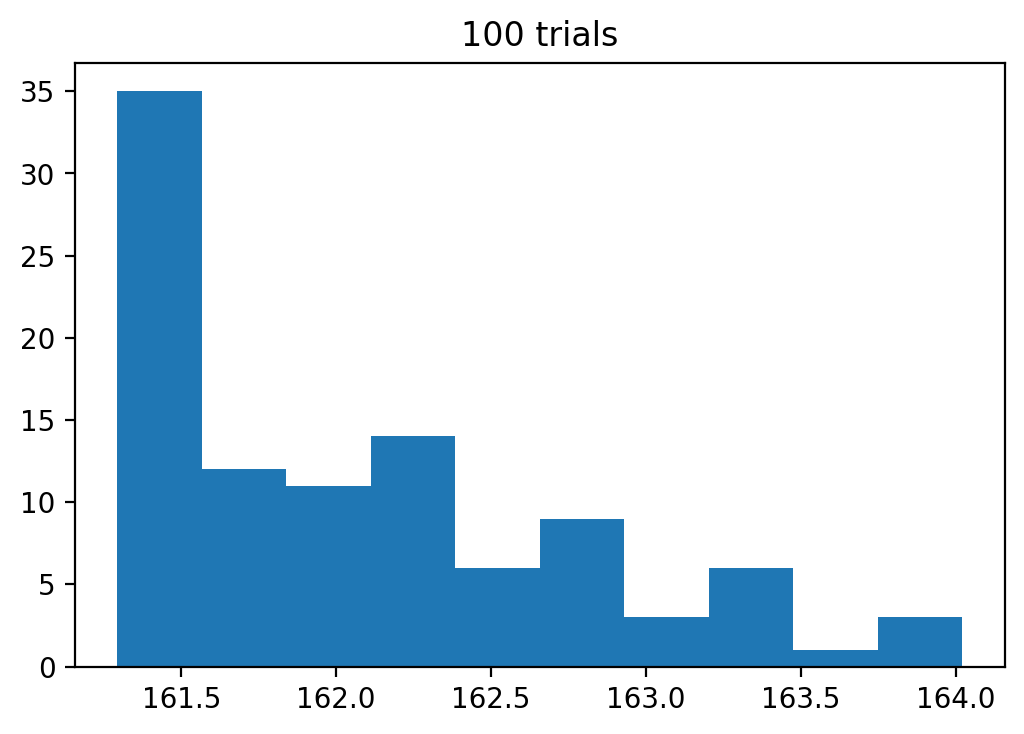

In [73]:
plt.hist(results)
plt.title("100 trials")
plt.savefig("100trials0.02kappa.png")
plt.show()

In [16]:
import random
# try a certain times and see how many converges
CUTOFF = 140
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = 0.15 # max(venus.get_noise_level(), 1e-5)
    print(noise)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))   
def trial2(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = max(venus.get_noise_level(), 1e-5)
    
    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    # print("Results:", results)
    n_succ = sum([i>=CUTOFF for i in results]) / len(results)
    return n_succ, results

# Fair coin problem
# prior is f(p) = 1 for p in range [0,1]  
# observation O is H positive in N trials  
# ask: what is the posterior f(p|O)
# f(p|O) = Pr(O|p) * f(p) / Pr(O) = Pr(O|p) * f(p) * const.
# f(p|O) ~ p^H * (1-p)^(N-H)
# var(p|O) = E((p|O)^2) - E(p|O)^2
#          = [continued in mathematica "Parameter Exploration - Theory and Simulation/FairCoinProb Posterior.nb"]
def FairCoinVar(H, N):
    return (1 - H**2 + N + H * N)/((2 + N)**2 * (3 + N))
FairCoinVar(10, 100) ** (1/2)

# TODO; double check this equatio with Marco

0.030563159973920874

In [17]:
trial2(10, n_iter = 10, init_points = 5, kappa = 2.3, verbose = 0)

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


(0.3,
 [117.795467291865,
  135.32957842323546,
  139.9576640645143,
  132.36527172414574,
  147.63878577588008,
  147.61698828570627,
  146.4641284074362,
  136.20732662657875,
  136.65925865419493,
  136.89700106663082])

In [21]:
REPEATS = 3
N_ITER = 40
succ_rates = []
results_list = []
kappas = np.linspace(1.5, 4, 3)
for kappa in kappas:
    succ_rate, results = trial2(REPEATS, n_iter = N_ITER, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

100%|██████████| 3/3 [00:09<00:00,  3.15s/it]


In [22]:
np.savetxt("results%drepeat%diter.csv"%(REPEATS,N_ITER), np.array(results_list))

In [23]:
results_list = np.loadtxt("results%drepeat%diter.csv"%(REPEATS,N_ITER))
results_list.shape

(3, 3)

In [24]:
REPEATS

3

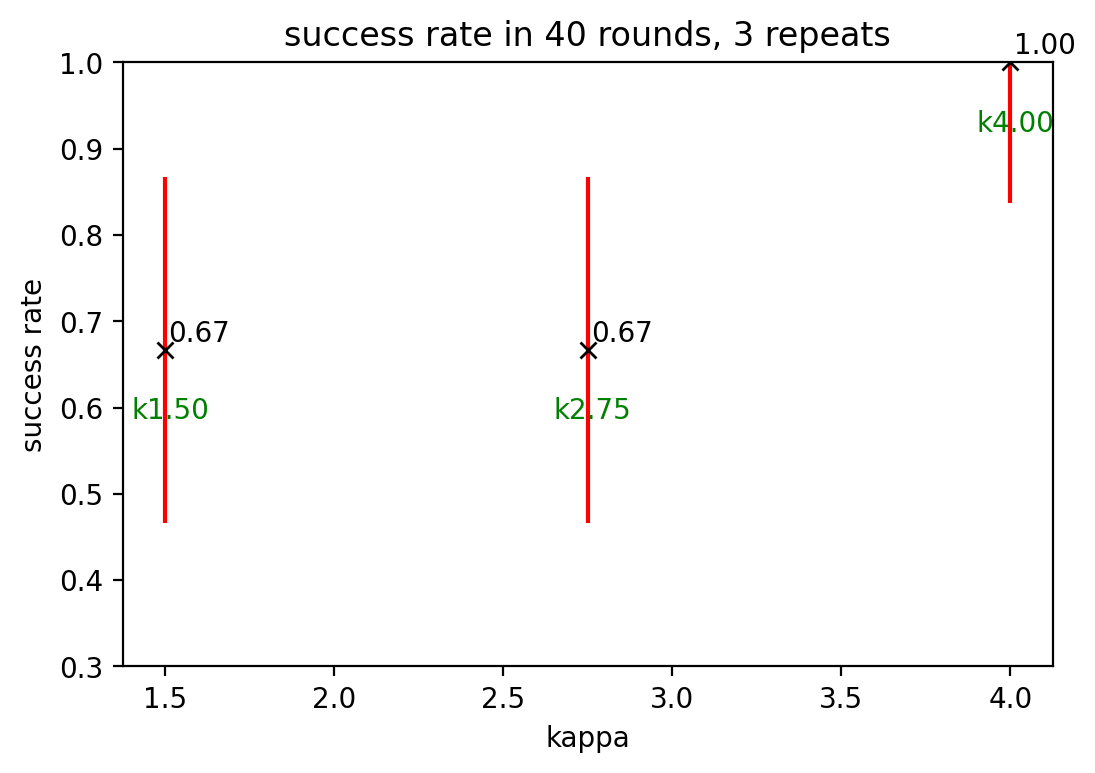

In [25]:
succ_rate_err = [FairCoinVar(rate*REPEATS, REPEATS) ** (1/2) for rate in succ_rates]
plt.errorbar(kappas, succ_rates, yerr=succ_rate_err, fmt="x", color='black', ecolor="red")
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.ylim([0.3,1])
plt.title("success rate in %d rounds, %d repeats"%(N_ITER, REPEATS))
dist = kappas[2]-kappas[1]
for index, value in enumerate(succ_rates):
    x = kappas[index]
    plt.text(x+0.01, value+0.01, "%.2f"%value)
    plt.text(x-0.1, value-0.08, "k%.2f"%x, color="green")
plt.savefig("Graphs/succ_rate%drepeats%diters.png"%(REPEATS, N_ITER))
plt.show()

In [ ]:
MIN = 100
MAX = 150
hist_bin = list(np.linspace(MIN, MAX, 10))
hist_list = []
for results in results_list:
    hist, bins = np.histogram(results, bins=hist_bin)
    hist_list.append(hist)
hist_results = np.vstack(hist_list).T[::-1]
hist_bin = [round(h,2) for h in hist_bin][:-1][::-1] # data manipulation for plots

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hist_results)

# avg_list = [(sum(results)/len(results)-MIN)/(MAX-MIN) for results in results_list]
# ax.plot(avg_list, color="red")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(kappas)))
ax.set_xticklabels([round(k,2) for k in kappas])
ax.set_yticks(np.arange(len(hist_bin)))
ax.set_yticklabels(hist_bin)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(hist_bin)):
    for j in range(len(kappas)):
        text = ax.text(j, i, hist_results[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Heatmap with %d repeats"%REPEATS)
fig.tight_layout()
plt.savefig("Graphs/heatmap%drepeats%diters.png"%(REPEATS, N_ITER))
plt.show()

In [ ]:
REPEATS = 100
N_ITER = 40
succ_rates = []
results_list = []
alphas = np.linspace(0.01, 1, 10)
for alpha in alphas:
    succ_rate, results = trial2(REPEATS, n_iter = N_ITER, init_points = 3, kappa = 2.3, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

## Simple Trial

In [ ]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

In [ ]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

In [ ]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)